# Load data

In [1]:
import pandas as pd

from os.path import join as path_join

from config import DATA_DIR

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_parquet(path_join(DATA_DIR, 'movie_reviews.parquet'))
print(data.shape)
print('-' * 20)
print(f'Target distribution:\n{data.target.value_counts(normalize=True)}')
data.sample(5, random_state=32421)

(2000, 2)
--------------------
Target distribution:
1    0.5
0    0.5
Name: target, dtype: float64


,text,target
205,the second serial - killer thriller of the mon...,0
564,my giant begins with a monologue that ' s more...,0
750,"disney ' s "" air bud "" tells a boy - and - his...",0
1013,"synopsis : in this movie , steven spielberg , ...",1
1897,"i must admit that i was a tad skeptical of "" g...",1


# Imports

In [3]:
from metrics import my_metric

from timeit_ import timeit_context

In [4]:
def model_name(model):
    return type(model).__name__

# Experiments

In [5]:
import lightgbm

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [6]:
%load_ext autoreload
%autoreload 2
from models.linear_regression import LinearModel
from models.lgbmachine import LGBMachine
from models import get_lgb, get_linear

## CountVectorizer
##### Some  experiments with CountVectorizer

In [9]:
vectorizer = CountVectorizer()

In [9]:
%%time

for classifier in [MultinomialNB(), LogisticRegression(random_state=123142), LinearSVC(random_state=124), SGDClassifier(random_state=134)]:
    model = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', classifier),
    ])
    with timeit_context('Time execution'):
        print(f'{model_name(classifier)}:  {my_metric(classifier=model)*100:.2f}%')
    print('-' * 30)

MultinomialNB:  81.85%
Time execution:	4.91sec
------------------------------
LogisticRegression:  84.75%
Time execution:	5.94sec
------------------------------
LinearSVC:  84.00%
Time execution:	8.50sec
------------------------------
SGDClassifier:  79.60%
Time execution:	5.02sec
------------------------------
CPU times: user 28.5 s, sys: 112 ms, total: 28.6 s
Wall time: 24.4 s


### LogReg + hyperparameters optimization

In [10]:
with timeit_context('Get best linear model'):
    classifier = get_linear(x_train=vectorizer.fit_transform(data['text']).toarray(), y_train=data['target'].values)
    
model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier),
])
with timeit_context('Time execution'):
    print(f'{model_name(classifier)} {my_metric(classifier=model)*100:.2f}%')

100%|██████████| 10/10 [00:40<00:00,  4.09s/it, best loss: -0.842]
Get best linear model:	42.14sec
LinearModel 81.90%
Time execution:	6.18sec


### Vectorizer tuning
Metrics:
- 84.65%
- 85.00%
- 83.90%
- 84.15%
- 83.95%
- 83.75%
- 79.70%
- 85.00%

In [8]:
%load_ext autoreload
%autoreload 2
    
from preprocessing import Tokenizer

In [77]:
word_vectorizer = CountVectorizer(
    lowercase     = True, 
    tokenizer     = lambda text: Tokenizer(stem='stem', splitter=None, remove_spec=True).tokenize(text), 
    stop_words    = stopwords,
    ngram_range   = (1, 2),
    analyzer      = 'word',
    max_df        = 1.0,
    min_df        = 1,
    max_features  = 10000,
)

char_vectorizer = CountVectorizer(
    lowercase     = True, 
    tokenizer     = None, 
    ngram_range   = (3, 5),
    analyzer      = 'char',
    max_df        = 0.95,
    min_df        = 10,
    max_features  = 1000,
)

classifier = LogisticRegression(random_state=123142)
model = Pipeline([
#     ('vectorizer', FeatureUnion([('word', word_vectorizer), ('char', char_vectorizer)])),
#     ('vectorizer', char_vectorizer),
    ('vectorizer', word_vectorizer),
    ('classifier', classifier),
])
with timeit_context('Time execution'):
    print(f'{model_name(classifier)}:  {my_metric(classifier=model)*100:.2f}%')

LogisticRegression:  85.00%
Time execution:	1min 53.54sec


In [79]:
with timeit_context('Get best linear model'):
    classifier = get_linear(x_train=word_vectorizer.fit_transform(data['text']).toarray(), y_train=data['target'].values)
    
model = Pipeline([
    ('vectorizer', word_vectorizer),
    ('classifier', classifier),
])
with timeit_context('Time execution'):
    print(f'{model_name(classifier)} {my_metric(classifier=model)*100:.2f}%')

100%|██████████| 10/10 [00:11<00:00,  1.15s/it, best loss: -0.827]
Get best linear model:	33.20sec
LinearModel 82.20%
Time execution:	1min 50.20sec


# TF/IDF
##### Some experiments with TFIDF vectorizer

In [9]:
vectorizer = TfidfVectorizer()

In [14]:
%%time

for classifier in [MultinomialNB(), LogisticRegression(random_state=123142), LinearSVC(random_state=124), SGDClassifier(random_state=134)]:
    model = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', classifier),
    ])
    with timeit_context('Time execution'):
        print(f'{model_name(classifier)}:  {my_metric(classifier=model)*100:.2f}%')
    print('-' * 30)

MultinomialNB:  80.85%
Time execution:	4.66sec
------------------------------
LogisticRegression:  82.00%
Time execution:	5.06sec
------------------------------
LinearSVC:  85.70%
Time execution:	5.28sec
------------------------------
SGDClassifier:  84.70%
Time execution:	5.03sec
------------------------------
CPU times: user 22.1 s, sys: 68.4 ms, total: 22.2 s
Wall time: 20 s


### LogReg + hyperparameters optimization

In [15]:
with timeit_context('Get best linear model'):
    classifier = get_linear(x_train=vectorizer.fit_transform(data['text']).toarray(), y_train=data['target'].values)
    
model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier),
])
with timeit_context('Time execution'):
    print(f'{model_name(classifier)} {my_metric(classifier=model)*100:.2f}%') 

100%|██████████| 10/10 [00:24<00:00,  2.49s/it, best loss: -0.852]
Get best linear model:	25.79sec
LinearModel 85.65%
Time execution:	5.47sec


### Vectorizer tuning

In [80]:
from preprocessing import Tokenizer

In [16]:
vectorizer = TfidfVectorizer(
    lowercase    = True,
    tokenizer    = lambda text: Tokenizer(stem='stem', splitter=None, remove_spec=True).tokenize(text), 
    analyzer     = 'word', 
    ngram_range  = (1, 2),
    max_df       = 0.8,
    min_df       = 10, 
    max_features = 100000,
    norm         = 'l2',
    use_idf      = True,
    smooth_idf   = True,
)

classifier = LogisticRegression(random_state=123142)
model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier),
])
with timeit_context('Time execution'):
    print(f'{model_name(classifier)}:  {my_metric(classifier=model)*100:.2f}%')

In [83]:
with timeit_context('Get best linear model'):
    classifier = get_linear(x_train=vectorizer.fit_transform(data['text']).toarray(), y_train=data['target'].values)
    
model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier),
])
with timeit_context('Time execution'):
    print(f'{model_name(classifier)} {my_metric(classifier=model)*100:.2f}%')

100%|██████████| 10/10 [00:06<00:00,  1.57it/s, best loss: -0.8470000000000001]
Get best linear model:	28.71sec
LinearModel 86.30%
Time execution:	2min 2.28sec


#### Is it usefull to use blending of baselines model in this case?

In [49]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

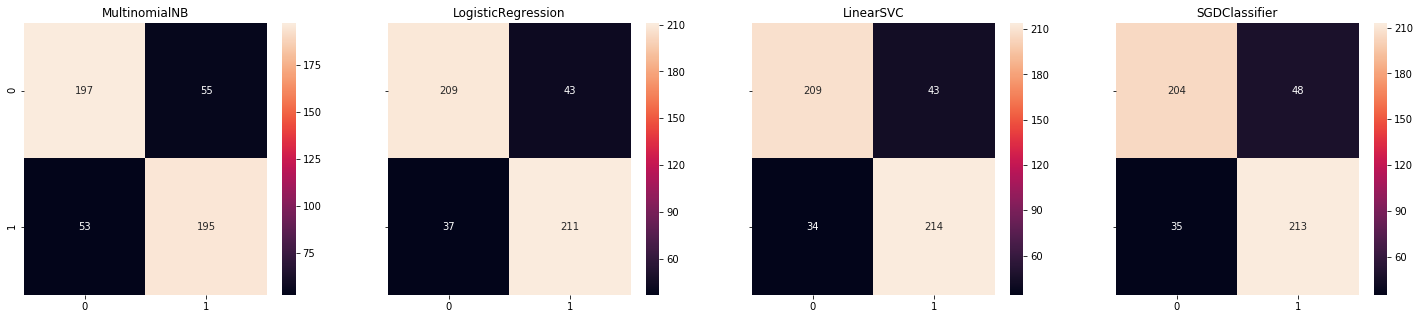

In [84]:
%%time

x_train, x_test, y_train, y_test = train_test_split(data['text'], data['target'], test_size=0.25, random_state=314)

f,(ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(25, 5))

for classifier, ax in zip([MultinomialNB(), LogisticRegression(random_state=123142), LinearSVC(random_state=124), SGDClassifier(random_state=134)],
                     [ax1, ax2, ax3, ax4]):
    model = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', classifier),
    ])
    model.fit(x_train, y_train)
    sns.heatmap(confusion_matrix(y_true=y_test, y_pred=model.predict(x_test)), 
                annot=True, annot_kws={"size": 10}, fmt="d", ax=ax).set_title(model_name(classifier))


##### It seems blending should not work, but whatever less try
- 85.65% (LogReg)
- 86.35% (LGB)
- 86.40%

In [147]:
%load_ext autoreload
%autoreload 2
from models import BlendingFeatures

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [152]:
vectorizer = TfidfVectorizer(
    lowercase    = True,
    tokenizer    = lambda text: Tokenizer(stem='stem', splitter=None, remove_spec=True).tokenize(text), 
    analyzer     = 'word', 
    ngram_range  = (1, 3),
    max_df       = 0.8,
    min_df       = 2, 
    max_features = 100000,
)

blending_features = BlendingFeatures([
    MultinomialNB(), LogisticRegression(random_state=123142), LinearSVC(random_state=124), SGDClassifier(random_state=134, loss='hinge'),
])
        
final_classifier = lightgbm.LGBMClassifier(random_state=123142, n_jobs=-1)
        
model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', blending_features),
    ('predictor', final_classifier)
])
with timeit_context('Time execution'):
    print(f'{model_name(final_classifier)}:  {my_metric(classifier=model)*100:.2f}%')
print('-' * 30)

/home/cyned/anaconda3/envs/ucu/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/cyned/anaconda3/envs/ucu/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/cyned/anaconda3/envs/ucu/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LGBMClassifier:  84.45%
Time execution:	1min 54.45sec
------------------------------


## RuleBased model
- 56.00%
- 65.50%
- 70.10%
- 68.35%

In [158]:
%load_ext autoreload
%autoreload 2
from models.rule_based import RuleBased

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [159]:
classifier = RuleBased()

with timeit_context('Time execution'):
    print(f'{model_name(classifier)} {my_metric(classifier=classifier)*100:.2f}%')

RuleBased 68.35%
Time execution:	2min 15.81sec


CPU times: user 31.4 s, sys: 80 ms, total: 31.5 s
Wall time: 31.6 s


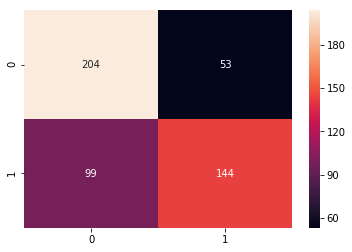

In [181]:
%%time

x_train, x_test, y_train, y_test = train_test_split(data['text'], data['target'], test_size=0.25, random_state=314)

model = RuleBased()
model.fit(x_train, y_train)
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=model.predict(x_test)), 
            annot=True, annot_kws={"size": 10}, fmt="d")

# RuleBased + Previous Blending

In [164]:
vectorizer = TfidfVectorizer(
    lowercase    = True,
    tokenizer    = lambda text: Tokenizer(stem='stem', splitter=None, remove_spec=True).tokenize(text), 
    analyzer     = 'word', 
    ngram_range  = (1, 3),
    max_df       = 0.8,
    min_df       = 2, 
    max_features = 100000,
)

blending_features = BlendingFeatures([
    MultinomialNB(), LogisticRegression(random_state=123142), LinearSVC(random_state=124), SGDClassifier(random_state=134, loss='hinge'),
])
        
final_classifier = lightgbm.LGBMClassifier(random_state=123142, n_jobs=-1)
        
model = Pipeline([
    ('blending_features', FeatureUnion([('ml_pipeline', Pipeline([('vectorizer', vectorizer), ('classifier', blending_features)])),
                  ('rule_based', RuleBased()),  
                 ])
    ),
    ('predictor', final_classifier)
])
('rule_based', RuleBased())
with timeit_context('Time execution'):
    print(f'{model_name(final_classifier)}:  {my_metric(classifier=model)*100:.2f}%')
print('-' * 30)

LGBMClassifier:  86.40%
Time execution:	6min 12.24sec
------------------------------


# Let's take a look at the embeddings
- 80.30%
- 81.30%
- 70.40%
- 80.90%
- 82.15%

In [6]:
from gensim.models.keyedvectors import KeyedVectors
from os.path import join as path_join
from config import APP_DIR

vec = KeyedVectors.load_word2vec_format(path_join(APP_DIR, 'wiki-news-300d-1M.vec')) 

In [63]:
%load_ext autoreload
%autoreload 2
from preprocessing.tokenizer import DictTokenizer, Tokenizer
from models import Doc2Vec
from models.utils import params_to_numpy
from models import get_lgb, LGBMachine

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
doc2vec = Doc2Vec(vec, tokenizer=DictTokenizer().tokenize)
classifier = lightgbm.LGBMClassifier(seed=134, n_jobs=-1)

model = Pipeline([
    ('vectorizer', doc2vec),
    ('predictor', classifier)
])
with timeit_context('Time execution'):
    print(f'{model_name(classifier)}:  {my_metric(classifier=model, verbose=3)*100:.2f}%')
print('-' * 30)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.785, total=  10.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.8s remaining:    0.0s


[CV]  ................................................................
[CV] ................................... , score=0.8125, total=   7.8s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   48.5s remaining:    0.0s


[CV]  ................................................................
[CV] ................................... , score=0.8175, total=   7.9s
[CV]  ................................................................
[CV] .................................... , score=0.825, total=   7.9s
[CV]  ................................................................
[CV] .................................... , score=0.805, total=   7.9s
LGBMClassifier:  80.90%
Time execution:	1min 45.13sec
------------------------------


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.8min finished


In [31]:
%%time

doc2vec = Doc2Vec(vec, tokenizer=DictTokenizer().tokenize)
with timeit_context('Get best lgb'):
    classifier = get_lgb(x_train=doc2vec.transform(data['text']), y_train=data['target'])

model = Pipeline([
    ('vectorizer', doc2vec),
    ('predictor', classifier)
])
with timeit_context('Time execution'):
    print(f'{model_name(classifier)}:  {my_metric(classifier=model, verbose=3)*100:.2f}%')
print('-' * 30)

100%|██████████| 10/10 [01:32<00:00,  9.95s/it, best loss: -0.8065]
Get best lgb:	1min 39.29sec


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................... , score=0.7825, total=  11.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.0s remaining:    0.0s


[CV]  ................................................................
[CV] ..................................... , score=0.81, total=  11.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   46.5s remaining:    0.0s


[CV]  ................................................................
[CV] .................................... , score=0.835, total=  12.8s
[CV]  ................................................................
[CV] .................................... , score=0.845, total=  16.1s
[CV]  ................................................................
[CV] .................................... , score=0.835, total=  11.6s
LGBMachine:  82.15%
Time execution:	2min 3.13sec
------------------------------
CPU times: user 9min 29s, sys: 6.87 s, total: 9min 35s
Wall time: 3min 42s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.1min finished


# Feature engineering
- 86.04

In [12]:
%load_ext autoreload
%autoreload 2
    
from preprocessing import FeaturesMaker, Tokenizer
from models import BlendingFeatures, RuleBased

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
vectorizer = TfidfVectorizer(
    lowercase    = True,
    tokenizer    = lambda text: Tokenizer(stem='stem', splitter=None, remove_spec=True).tokenize(text), 
    analyzer     = 'word', 
    ngram_range  = (1, 3),
    max_df       = 0.8,
    min_df       = 2, 
    max_features = 100000,
)

blending_features = BlendingFeatures([
    MultinomialNB(), LogisticRegression(random_state=123142), LinearSVC(random_state=124), SGDClassifier(random_state=134, loss='hinge'),
])
        
final_classifier = lightgbm.LGBMClassifier(random_state=123142, n_jobs=-1)
        
model = Pipeline([
        ('blending_features', FeatureUnion([('ml_pipeline', Pipeline([('vectorizer', vectorizer), ('classifier', blending_features)])),
        ('rule_based', RuleBased()), ('feature_engine', FeaturesMaker()) 
    ])),
    ('predictor', final_classifier)
])
with timeit_context('Time execution'):
    print(f'{model_name(final_classifier)}:  {my_metric(classifier=model, verbose=2)*100:.2f}%')
print('-' * 30)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total= 1.3min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV] ................................................. , total= 1.3min
[CV]  ................................................................
[CV] ................................................. , total= 1.4min
[CV]  ................................................................
[CV] ................................................. , total= 1.3min
[CV]  ................................................................
[CV] ................................................. , total= 1.3min
LGBMClassifier:  84.55%
Time execution:	6min 35.61sec
------------------------------


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.6min finished


# Let us create one huge Pipeline that gather all
It seems not a good idea but let do an experiment

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from models import RuleBased, Doc2Vec, BlendingFeatures
from preprocessing import Tokenizer, FeaturesMaker, DictTokenizer

In [21]:
from gensim.models.keyedvectors import KeyedVectors
from os.path import join as path_join
from config import APP_DIR

vec = KeyedVectors.load_word2vec_format(path_join(APP_DIR, 'wiki-news-300d-1M.vec')) 

In [24]:
word_vectorizer = CountVectorizer(
    lowercase     = True, 
    tokenizer     = lambda text: Tokenizer(stem='stem', splitter=None, remove_spec=True).tokenize(text), 
    ngram_range   = (1, 2),
    analyzer      = 'word',
    max_df        = 1.0,
    min_df        = 1,
    max_features  = 10000,
)

char_vectorizer = CountVectorizer(
    lowercase     = True, 
    tokenizer     = None, 
    ngram_range   = (3, 5),
    analyzer      = 'char',
    max_df        = 0.95,
    min_df        = 10,
    max_features  = 1000,
)

tfidf_vectorizer = TfidfVectorizer(
    lowercase    = True,
    tokenizer    = lambda text: Tokenizer(stem='stem', splitter=None, remove_spec=True).tokenize(text), 
    analyzer     = 'word', 
    ngram_range  = (1, 3),
    max_df       = 0.8,
    min_df       = 2, 
    max_features = 100000,
)

doc2vec = Doc2Vec(vec, tokenizer=DictTokenizer().tokenize)

word_blending = BlendingFeatures([
    MultinomialNB(), LogisticRegression(random_state=123142), LinearSVC(random_state=124), SGDClassifier(random_state=134, loss='hinge'),
])
char_blending = BlendingFeatures([
    MultinomialNB(), LogisticRegression(random_state=123142), LinearSVC(random_state=124), SGDClassifier(random_state=134, loss='hinge'),
])
tfidf_blending = BlendingFeatures([
    MultinomialNB(), LogisticRegression(random_state=123142), LinearSVC(random_state=124), SGDClassifier(random_state=134, loss='hinge'),
])
emb_classifier = lightgbm.LGBMClassifier(seed=134, n_jobs=-1)

In [26]:
word_pipeline = Pipeline([
    ('vectorizer', word_vectorizer),
    ('predictor', word_blending)
])
char_pipeline = Pipeline([
    ('vectorizer', char_vectorizer),
    ('predictor', char_blending)
])
tfidf_pipeline = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', tfidf_blending)
])
emb_pipeline = Pipeline([
    ('vectorizer', doc2vec),
    ('clasifier', emb_classifier)
])
        
final_classifier = lightgbm.LGBMClassifier(random_state=123142, n_jobs=-1)
        
model = Pipeline([('features', FeatureUnion([
    ('word_pipeline', word_pipeline),
    ('char_pipeline', char_pipeline),
    ('tfidf_pipeline', tfidf_pipeline),
    ('rule_based', RuleBased()),
    ('feature_engine', FeaturesMaker()), 
])),
    ('predictor', final_classifier)
])
with timeit_context('Time execution'):
    print(f'{model_name(final_classifier)}:  {my_metric(classifier=model, verbose=4)*100:.2f}%')
print('-' * 30)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................


[CV] ................................... , score=0.8275, total= 1.9min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s


[CV] ................................... , score=0.8275, total= 2.0min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.9min remaining:    0.0s


[CV] .................................... , score=0.865, total= 2.0min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.9min remaining:    0.0s


[CV] .................................... , score=0.835, total= 2.1min
[CV]  ................................................................


[CV] ................................... , score=0.8175, total= 2.0min
LGBMClassifier:  83.45%
Time execution:	9min 58.59sec
------------------------------


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 10.0min finished


# Transfer learning
Maybe we should pretrain some LightGBM model on bigger dataset and use continuous learning in the cross val metric? (big_data was formed in Analyze.ipynb module)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from models import Doc2Vec

In [13]:
big_data = pd.read_parquet(path_join(DATA_DIR, 'big_data.parquet'))
big_data_x = big_data.text
big_data_y = big_data.target

x_train, x_test, y_train, y_test = train_test_split(data['text'], data['target'], test_size=0.25, random_state=314)

In [14]:
%load_ext autoreload
%autoreload 2

# doc2vec = Doc2Vec(
#     word2vec=vec, 
#     tokenizer = Tokenizer(stem='lem', remove_spec=True).tokenize,
# )

tfidf_vectorizer = TfidfVectorizer(
    lowercase    = True,
    tokenizer    = lambda text: Tokenizer(stem='stem', splitter=None, remove_spec=True).tokenize(text), 
    analyzer     = 'word', 
    ngram_range  = (1, 3),
    max_df       = 0.8,
    min_df       = 2, 
    max_features = 100000,
)
classifier = LogisticRegression(random_state=1324, n_jobs=-1)
lgb = lightgbm.LGBMClassifier(seed=124, n_jobs=-1)

model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('classifier', classifier),
])

# lgb_model = Pipeline([
#     ('vectorizer', doc2vec),
#     ('classifier', lgb),
# ])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Logistic Regression
Let compare different x_train variants

In [36]:
%%time

with timeit_context('Fitting time'):
    model.fit(big_data_x, big_data_y)

with timeit_context('Pred time'):
    preds = model.predict(x_test)
    print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=preds)*100:.2f}%')

Accuracy: 88.00%
CPU times: user 4.99 s, sys: 12 µs, total: 4.99 s
Wall time: 5 s


In [38]:
%%time

with timeit_context('Fitting time'):
    model.fit(x_train, y_train)

with timeit_context('Pred time'):
    preds = model.predict(x_test)
    print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=preds)*100:.2f}%')

Fitting time:	20.12sec
Accuracy: 84.40%
Pred time:	5.53sec
CPU times: user 25.7 s, sys: 112 ms, total: 25.8 s
Wall time: 25.6 s


In [48]:
%%time

with timeit_context('Fitting time'):
    model.fit(list(big_data_x.values) + list(x_train.values), list(big_data_y.values) + list(y_train.values))

with timeit_context('Pred time'):
    preds = model.predict(x_test)
    print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=preds)*100:.2f}%')

Fitting time:	4min 40.44sec
Accuracy: 89.60%
Pred time:	5.30sec
CPU times: user 4min 43s, sys: 3.2 s, total: 4min 46s
Wall time: 4min 45s


### LightGBM
Let compare different x_train variants

In [79]:
%%time

with timeit_context('Fitting time'):
    lgb_model.fit(x_train.values, y_train.values)

with timeit_context('Pred time'):
    preds = lgb_model.predict(x_test)
    print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=preds)*100:.2f}%')

Fitting time:	12.92sec
Accuracy: 83.60%
Pred time:	2.88sec
CPU times: user 27 s, sys: 292 ms, total: 27.3 s
Wall time: 15.8 s


In [184]:
with timeit_context('Fitting time'):
    lgb_model.fit(big_data_x, big_data_y)

with timeit_context('Pred time'):
    preds = lgb_model.predict(x_test)
    print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=preds)*100:.2f}%')

Fitting time:	1min 12.73sec
Accuracy: 82.00%
Pred time:	2.10sec


In [144]:
%%time

with timeit_context('Fitting time'):
    lgb_model.fit(list(big_data_x.values) + list(x_train.values), list(big_data_y.values) + list(y_train.values))

with timeit_context('Pred time'):
    preds = lgb_model.predict(x_test)
    print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=preds)*100:.2f}%')

Fitting time:	1min 18.62sec
Accuracy: 81.40%
Pred time:	2.11sec
CPU times: user 1min 49s, sys: 250 ms, total: 1min 50s
Wall time: 1min 20s


In [190]:
lgb_model.get_params()['steps'][1][1].booster_.save_model('light.txt')

### Pipeline
Let compare different x_train variants

In [10]:
from sklearn.model_selection import KFold
from tqdm import tqdm
import numpy as np
from models import BlendingFeatures
from preprocessing import Tokenizer

In [8]:
vectorizer = TfidfVectorizer(
    lowercase    = True,
    tokenizer    = lambda text: Tokenizer(stem='stem', splitter=None, remove_spec=True).tokenize(text), 
    analyzer     = 'word', 
    ngram_range  = (1, 3),
    max_df       = 0.8,
    min_df       = 2, 
    max_features = 100000,
)

blending_features = BlendingFeatures([
    MultinomialNB(), LogisticRegression(random_state=123142), LinearSVC(random_state=124), SGDClassifier(random_state=134, loss='hinge'),
])
        
model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', blending_features),
])

In [15]:
kfold = KFold(random_state=1324, n_splits=3, shuffle=True)

mnb = MultinomialNB()
log = LogisticRegression(random_state=123142)
lin = LinearSVC(random_state=124)
sgd = SGDClassifier(random_state=134)
    
meta_features = np.array([None] * big_data_x.shape[0])
for train_index, test_index in tqdm(kfold.split(big_data_x), total=3):
    train_data = vectorizer.fit_transform(big_data_x.iloc[train_index])
    test_data  = vectorizer.transform(big_data_x.iloc[test_index])
    mnb.fit(train_data, big_data_y.iloc[train_index])
    lin.fit(train_data, big_data_y.iloc[train_index])
    log.fit(train_data, big_data_y.iloc[train_index])
    sgd.fit(train_data, big_data_y.iloc[train_index])
    meta_features[test_index] = list(zip(
        mnb.predict_proba(test_data)[:, 1], 
        log.predict_proba(test_data)[:, 1],
        lin.predict(test_data),
        sgd.predict(test_data),
    ))

100%|██████████| 3/3 [10:22<00:00, 208.59s/it]


In [16]:
meta = np.array([np.array(i) for i in meta_features])

In [52]:
%load_ext autoreload
%autoreload 2
from models import get_lgb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
# lgb = lightgbm.LGBMClassifier(seed=124, n_jobs=-1).fit(meta, big_data_y.values)
lgb = get_lgb(meta, big_data_y.values)
# lgb_model.get_params()['steps'][1][1].booster_.save_model('light.txt.init')
lgb.model.booster_.save_model('light.txt.init')

100%|██████████| 50/50 [01:33<00:00,  1.56s/it, best loss: -0.89748]


In [54]:
lgb.model

LGBMClassifier(bagging_fraction=0.75, boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, feature_fraction=0.8,
        importance_type='split', learning_rate=0.061500000000000006,
        max_depth=3, max_drop=33, min_child_samples=20,
        min_child_weight=0.001, min_data_in_leaf=62, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_iterations=151, num_leaves=77,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

# Transfer learning
### Let's try transfer learning with lgb
- 76.7%
- 85.55%
- 86.05%

In [7]:
class Light(object):
    def __init__(self, model_path, threshold: float = 0.5):
        self.model_path = model_path
        self.model = None
        self.threshold = threshold
        
    def fit(self, x_train, y_train):
        self.model = lightgbm.train(params={}, train_set=lightgbm.Dataset(x_train, y_train), init_model=self.model_path)
        return self
        
    def predict(self, x_test):
        return [i > self.threshold for i in self.model.predict(x_test)]
    
    
light_model = Light(model_path='light.txt.init')

lgb_model1 = Pipeline([
    ('vectorizer', doc2vec),
    ('classifier', light_model),
])

with timeit_context('Time execution'):
    print(f'{model_name(final_classifier)}:  {my_metric(classifier=lgb_model1, verbose=4)*100:.2f}%')
print('-' * 30)

NameError: name 'doc2vec' is not defined

In [55]:
%load_ext autoreload
%autoreload 2

from models.blending import BlendingFeatures

blending_features = BlendingFeatures([
    MultinomialNB(),
    LogisticRegression(random_state=123142), LinearSVC(random_state=124), SGDClassifier(random_state=134, loss='hinge'),
])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
lgb.model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.061500000000000006,
 'max_depth': 3,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 77,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'bagging_fraction': 0.75,
 'feature_fraction': 0.8,
 'max_drop': 33,
 'min_data_in_leaf': 62,
 'num_iterations': 151}

In [56]:
class Light(object):
    def __init__(self, model_path, threshold: float = 0.5):
        self.model_path = model_path
        self.model      = None
        self.threshold  = threshold
        
    def fit(self, x_train, y_train):
        self.model = lightgbm.train(params={'seed': 123, 'n_jobs': -1}, train_set=lightgbm.Dataset(x_train, y_train), init_model=self.model_path)
        return self
        
    def predict(self, x_test):
        return [i > self.threshold for i in self.model.predict(x_test)]

light = Light(model_path='light.txt.init')
model = Pipeline([
    ('vectorizer', vectorizer),
    ('blending', blending_features),
    ('final_classfier', light)
])

with timeit_context('Time execution'):
    print(f'{model_name(light)}:  {my_metric(classifier=model, verbose=4)*100:.2f}%')
print('-' * 30)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.3s remaining:    0.0s


[CV] ................................... , score=0.8725, total=  24.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   48.0s remaining:    0.0s


[CV] .................................... , score=0.845, total=  23.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s


[CV] ................................... , score=0.8875, total=  23.6s
[CV]  ................................................................


[CV] .................................... , score=0.855, total=  23.8s
[CV]  ................................................................


[CV] ................................... , score=0.8425, total=  23.5s
Light:  86.05%
Time execution:	1min 59.36sec
------------------------------


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min finished


# VedarModel
- 50.00%
- 62.50%
- 61.95%

In [40]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
from copy import deepcopy

class Vedar(BaseEstimator):
    def __init__(self, eval_metric = accuracy_score):
        self.analyser = SentimentIntensityAnalyzer()
        self.threshold = 0.0
        self.eval_metric = eval_metric
        
    def fit(self, x_train, y_train):
        predictions = [self.analyser.polarity_scores(sample) for sample in x_train]
        predictions = np.array([pred['pos'] + pred['neu'] * 0.5 for pred in predictions])
        eval_metrics = []
        thrs         = []
        for thr in np.arange(0.05, 0.9, 0.05):
            eval_metrics.append(self.eval_metric(predictions > thr, y_train))
            thrs.append(thr)
        self.threshold = thrs[np.argmax(eval_metrics)]
        
        # return (pos - neg) / (max([pos, neg]))
        # return pos / (pos + neg)

        return self
    
    def predict(self, x_test):
        predictions = [self.analyser.polarity_scores(sample) for sample in x_test]
        print(predictions)
        return np.array([pred['pos'] + pred['neu'] * 0.5 > self.threshold for pred in predictions])
    
vedar = Vedar()

with timeit_context('Time execution'):
    print(f'{model_name(vedar)}:  {my_metric(classifier=vedar, verbose=4, n_jobs=-1)*100:.2f}%')
print('-' * 30)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.8min remaining:  4.2min


Vedar:  61.95%
Time execution:	3min 55.92sec
------------------------------


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.9min finished
